/var/folders/kn/fwnw3jp94k7f92srh58xkgxr0000gn/T/ipykernel_3974/2025586629.py:250: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], matlab.mio5_params.mat_struct):
/var/folders/kn/fwnw3jp94k7f92srh58xkgxr0000gn/T/ipykernel_3974/2025586629.py:279: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(sub_elem, matlab.mio5_params.mat_struct):
/var/folders/kn/fwnw3jp94k7f92srh58xkgxr0000gn/T/ipykernel_3974/2025586629.py:263: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, matlab.mio5_params.mat_struct):


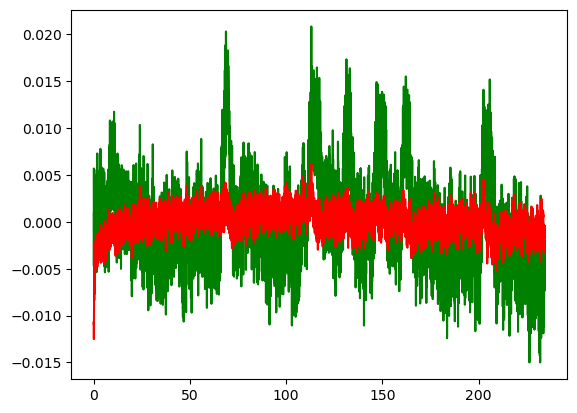

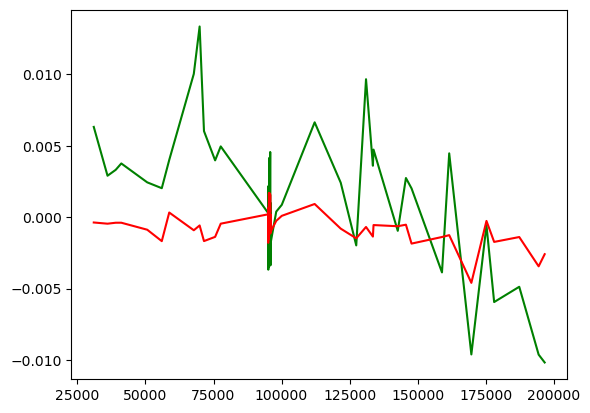

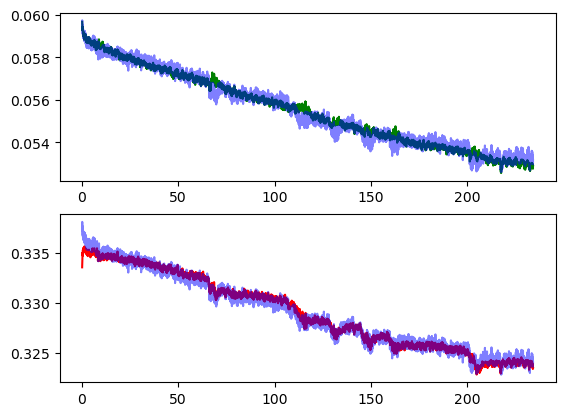

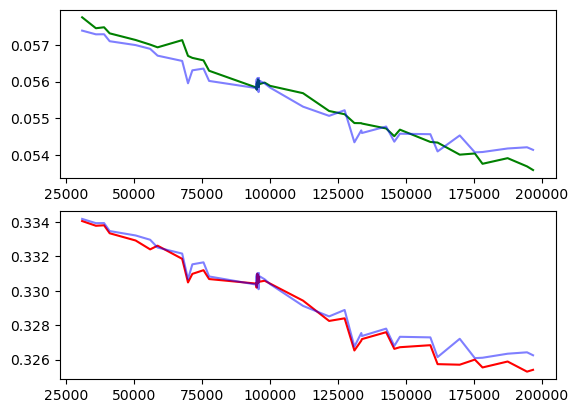

In [138]:
#CELL 1

#Establish Mouse Signal and Time Dictionary
#Establish DFF across all time

import numpy as np
import scipy.ndimage as nd
from scipy.io import loadmat
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pickle as p
#import functions.data_io as dataio
#import functions.plot as plot
import os
import re
import h5py

directory = '/Users/rishachakraborty/Downloads'

datanames = ['_FPConsole_Signals_Series0001_DigitalIO','_FPConsole_Signals_Series0001_AIN01xAOUT01-LockIn','_FPConsole_Signals_Series0001_AIN01xAOUT02-LockIn','_FPConsole_Signals_Series0001_AIN02xAOUT03-LockIn']

datanames_new = ['TTL1','TTL2','405','470','568']

dataprobe = load_doric('/Users/rishachakraborty/Downloads/HJ_FP_Rdlight_F1_0006.doric', 6, datanames, datanames_new)
correspondingmat = load_mat('/Users/rishachakraborty/Downloads/JF_VR_FP_M4_cues_230721-141046.mat')
newphotometry = synctimestamps(dataprobe,correspondingmat)

#obtain DFFs only from photometry data
dff470phottimes = calculateDFF(np.array(dataprobe['405']), np.array(dataprobe['470']))
dff568phottimes = calculateDFF(np.array(dataprobe['405']), np.array(dataprobe['568']))

#obtain DFFS from new photometry data (with timess corresponding to matfile times)
dff470mattimes = calculateDFF(np.array(newphotometry['405']), np.array(newphotometry['470']))
dff568mattimes = calculateDFF(np.array(newphotometry['405']), np.array(newphotometry['568']))


#Plot DFFS from photometry time
plt.figure()
plt.plot(dataprobe['time'], dff470phottimes, color = "green")
plt.plot(dataprobe['time'], dff568phottimes, color = "red")

#Plot DFFs from matfile time
plt.figure()
plt.plot(newphotometry['time'], dff470mattimes, color = "green")
plt.plot(newphotometry['time'], dff568mattimes, color = "red")


#Plot Fitted405 against Unadjusted Signal curves from photometry time

fig,axs = plt.subplots(2, 1)
axs[0].plot(dataprobe['time'],dataprobe['470'],color = "green")
axs[0].plot(dataprobe['time'],np.polyval(linreg(np.array(dataprobe['405']),np.array(dataprobe['470'])), np.array(dataprobe['405'])),color = "blue", alpha = 0.5)

axs[1].plot(dataprobe['time'],dataprobe['568'],color = "red")
axs[1].plot(dataprobe['time'],np.polyval(linreg(np.array(dataprobe['405']),np.array(dataprobe['568'])), np.array(dataprobe['405'])),color = "blue", alpha = 0.5)


#Plot Fitted405 against Unadjusted Signal curves from matfile time
fig,axs = plt.subplots(2, 1)
axs[0].plot(newphotometry['time'],newphotometry['470'],color = "green")
axs[0].plot(newphotometry['time'],np.polyval(linreg(np.array(newphotometry['405']),np.array(newphotometry['470'])), np.array(newphotometry['405'])),color = "blue", alpha = 0.5)

axs[1].plot(newphotometry['time'],newphotometry['568'],color = "red")
axs[1].plot(newphotometry['time'],np.polyval(linreg(np.array(newphotometry['405']),np.array(newphotometry['568'])), np.array(newphotometry['405'])),color = "blue", alpha = 0.5)



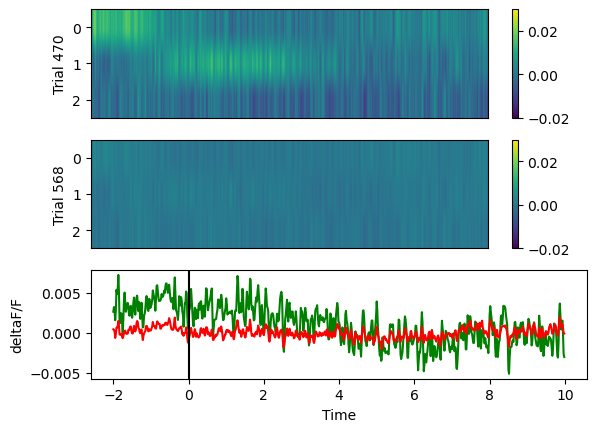

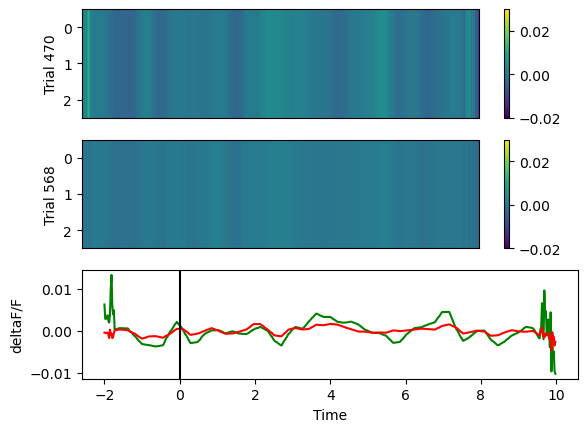

In [156]:
#get cuetimes from photometry data only using getcuetimes() and TTL2
cuetimesphot = photometrygetcuetimes(np.array(dataprobe['time']), np.array(dataprobe['TTL2']))

#get cuetimes from matfile data
cuetimesmat = matgetcuetimes(correspondingmat['eventlog'], 12)

#get dff across trials from photometry time 
dff470acrosstrialsphot = dicttoarray(dffacrosstrials(dff470phottimes,cuetimesphot,dataprobe['time'],-120,600))
dff568acrosstrialsphot = dicttoarray(dffacrosstrials(dff568phottimes,cuetimesphot,dataprobe['time'],-120,600))

#plot heatmap and averagedff from photometry time
averagedff470phot = np.mean(dff470acrosstrialsphot,axis=0)
averagedff568phot = np.mean(dff568acrosstrialsphot,axis=0)

fig,axs = plt.subplots(3, 1)

im1 = axs[0].imshow(dff470acrosstrialsphot,vmin = -0.02, vmax = 0.03, aspect='auto')
axs[0].set(ylabel='Trial 470', xticks = [])
fig.colorbar(im1)

im2 = axs[1].imshow(dff568acrosstrialsphot,vmin = -0.02, vmax = 0.03, aspect='auto')
axs[1].set(ylabel='Trial 568', xticks = [])
fig.colorbar(im2)

axs[2].plot(np.arange(-2,10,(1/60)),averagedff470phot,color = "green")
axs[2].plot(np.arange(-2,10,(1/60)),averagedff568phot,color = "red")
axs[2].set(xlabel = 'Time',ylabel = 'deltaF/F')
plt.axvline(0, color='black')

#get dff across trials from matfile time
dff470acrosstrialsmat = dicttoarray(dffacrosstrials(dff470mattimes,cuetimesmat,newphotometry['time'],-2000,10000))
dff568acrosstrialsmat = dicttoarray(dffacrosstrials(dff568mattimes,cuetimesmat,newphotometry['time'],-2000,10000))

#plot heatmap and averagedff from mat time
averagedff470mat = np.mean(dff470acrosstrialsmat,axis=0)
averagedff568mat = np.mean(dff568acrosstrialsmat,axis=0)

fig,axs = plt.subplots(3, 1)

im1 = axs[0].imshow(dff470acrosstrialsmat,vmin = -0.02, vmax = 0.03, aspect='auto')
axs[0].set(ylabel='Trial 470', xticks = [])
fig.colorbar(im1)

im2 = axs[1].imshow(dff568acrosstrialsmat,vmin = -0.02, vmax = 0.03, aspect='auto')
axs[1].set(ylabel='Trial 568', xticks = [])
fig.colorbar(im2)

axs[2].plot(np.arange(-2,10,(12/len(averagedff470mat))),averagedff470mat,color = "green")
axs[2].plot(np.arange(-2,10,(12/len(averagedff568mat))),averagedff568mat,color = "red")
axs[2].set(xlabel = 'Time',ylabel = 'deltaF/F')
plt.axvline(0, color='black')


In [151]:
from scipy import interpolate
from scipy.io import loadmat, matlab

def dffacrosstrials(dff,cuetimes,time,starttime,endtime):
    #dffacrosstrials = {}
    #for i in range(len(cuetimes)):
        #dffacrosstrials[i] = dff[np.where(np.logical_and(time >= cuetimes[i] + starttime, time <= cuetimes[i] + endtime))]
    #return dffacrosstrials
    dffacrosstrials = {}
    for i in range(len(cuetimes)):
        dffacrosstrials[i] = dff[(np.where(time >= cuetimes[i])[0][0]+starttime):(np.where(time <= cuetimes[i])[0][-1]+endtime)]
    return dffacrosstrials

def dicttoarray(dffdict):
    dffarray = dffdict[0]
    dffarray = dffarray.reshape(1,len(dffarray))
    for i in range(len(dffdict)):
        if i != 0:
            dffarray = np.vstack((dffarray,np.pad(dffdict[i],(0,np.shape(dffarray)[1]-len(dffdict[i])), mode = 'constant')))
    return dffarray

        #left = np.where(time == cuetimes[i])[0][0] + starttime
        #right = np.where(dataprobe['time'] == cuetimes[i])[0][0]+endtime
        #dffacrosstrials[i] = dff[left:right]
        #dffarray[0:len(dff[left:right])] = dff[left:right]
        #if i == 0:
          #  dffacrosstrials = dffarray
        #else:
            #dffacrosstrials = np.vstack((dffacrosstrials,dffarray))



def synctimestamps(photometrydata,matdata):
    #startindex = np.where(dataprobe['TTL1'])[0][0]
    #endindex = np.where(dataprobe['TTL1'])[0][-1]
    timesyncedphotometry = {}
    for i, v in enumerate(photometrydata):
        #f = interpolate.interp1d(np.array(photometrydata['time'][startindex:endindex]),np.array(photometrydata[v][startindex:endindex]),bounds_error = False)
        f = interpolate.interp1d(np.array(photometrydata['time']),np.array(photometrydata[v]),bounds_error = False)
        timesyncedphotometry[v] = f((np.array(matdata['eventlog'][:,1]))/1000)
    timesyncedphotometry['time'] = timesyncedphotometry['time']*1000
    return timesyncedphotometry

def calculateDFF(array1, array2):
    #array1 = array to be fitted
    #array2 = array to be fit to
    return (array2 - np.polyval(linreg(array1,array2), array1))/np.polyval(linreg(array1,array2), array1)

#get TTL2 signal times purely from photometry data
def photometrygetcuetimes(time,signal):
    timearray = [time[np.where(signal==1)][0]]
    for i in range(len(time[np.where(signal==1)])):
        if time[np.where(signal==1)][i] > (timearray[-1] + 1):
            timearray = np.append(timearray,time[np.where(signal==1)][i])
    return timearray

#get cue times from mat file
def matgetcuetimes(matfile,eventid):
    return matfile[:,1][matfile[:,0] == eventid]


def linreg(array1,array2):
    #array1 = array to be fitted
    #array2 = array to be fit to
    m = (np.count_nonzero(~np.isnan(array1)) * np.nansum(array1*array2) - np.nansum(array1) * np.nansum(array2)) / (np.count_nonzero(~np.isnan(array1))*np.nansum(array1*array1) - np.nansum(array1) ** 2)
    b = (np.nansum(array2) - m *np.nansum(array1)) / np.count_nonzero(~np.isnan(array1))
    return [m,b]

def ish5dataset(item):
    """Check if the given item is in HDF5 format. Function from doric.

    Args:
        item: any variable you want to know if it's format is HDF5

    Returns:
        boolean: 1 if item is HDF5, 0 if not.
    """
    return isinstance(item, h5py.Dataset)


def h5getDatasetR(item, leading=''):
    """Read data from HDF5 file. Function from doric.

     Args:
          item (h5fp file object w/ r mode): This can work as like a Python dictionary - you can access to its data using key.
          leading (str): leading string that you want to put before your key in the name (e.g., filepath)

    Returns:
        boolean: 1 if item is HDF5, 0 if not.

    """

    r = []
    for key in item:
        # First have to check if the next layer is a dataset or not
        firstkey = list(item[key].keys())[0]
        if ish5dataset(item[key][firstkey]):
            r = r + [{'Name': leading + '_' + key, 'Data':
                [{'Name': k, 'Data': np.array(item[key][k]),
                  'DataInfo': {atrib: item[key][k].attrs[atrib] for atrib in item[key][k].attrs}} for k in
                 item[key]]}]
        else:
            r = r + h5getDatasetR(item[key], leading + '_' + key)

    return r

def ExtractDataAcquisition(filename, version):
    """Main function that reads data from '.doric' file. Modified function provided by doric.

    Args:
        filename (str): Full file path of '.doric' file
        version (int): 5 or 6. Version number of Doric Neuroscience Studio. Key is different depending on version.

    Returns:
        The acquired data of '.doric' file, which includes time stamps, fluorescence signals (from 405 and 470nm), and
        TTL signals (from TTL 1 and TTL 2).
    """

    with h5py.File(filename, 'r') as h:
        if version == 5:
            return h5getDatasetR(h['Traces'])
        elif version == 6:
            return h5getDatasetR(h['DataAcquisition'])


def load_doric(filename, version, datanames, datanames_new):
    """Function to read doric data file (.doric) and save it in a general format.

    Args:
        filename (str): Full file path of '.doric' file
        version (int): 5 or 6. Version number of Doric Neuroscience Studio. Key is different depending on version.
        datanames (str list): Default data names in raw '.doric' file
        datanames_new (str list): The new data names. This should be the same across different photometry systems
            (doric and pyphotometry), so that we can easily access to the data using the same fundtion regardless of the
            data acquisition system.

    Returns:
        data (dict): Dictionary that stores all acquired data from doric. Keys are the datanames_new.
    """
    # TODO(HuijeongJeong): develop for version 6

    # Read doric data as a list of dictionary. Each dictionary contains default data name ('Name') in raw '.doric' file,
    # and corresponding data ('Data'). datanames should be a subset of Name of dictionaries.
    

    # save data in a pretty form with datanames_new
    
    #suggested datanames: datanames = ['_FPConsole_Signals_Series0001_DigitalIO','_FPConsole_Signals_Series0001_AIN01xAOUT01-LockIn','_FPConsole_Signals_Series0001_AIN01xAOUT02-LockIn','_FPConsole_Signals_Series0001_AIN02xAOUT03-LockIn']
    #corresponding datanames_new: datanames_new = ['TTL1','TTL2','405','470','568']
    
    
    data = {}
    
    if version == 5:
        doricfile = [data["Data"][0] for data in ExtractDataAcquisition(filename, 5)]
        
        # save time
        data['time'] = [data["Data"] for data in doricfile if data["Name"] == 'Console_time(s)'][0].tolist()
        
       # save other data
        for i, v in enumerate(datanames):
            data[datanames_new[i]] = [data["Data"] for data in doricfile if data["Name"] == v][0].tolist()
            
    elif version == 6:
        extractedData = ExtractDataAcquisition(filename, 6)
        dio = {}
        
        # save time
        data['time'] = [data["Data"] for data in [doricdata["Data"][0] for doricdata in extractedData] if data["Name"] == 'Time'][0].tolist()
     
       #save other data
        for i, v in enumerate(datanames):
            
            #save digital data
            if v == '_FPConsole_Signals_Series0001_DigitalIO':
                data['TTL1'] = [ddata["Data"] for ddata in [doricdata["Data"][0] for doricdata in extractedData if doricdata["Name"] == v] if ddata["Name"] == "DIO01"][0].tolist()
                data['TTL2'] = [ddata["Data"] for ddata in [doricdata["Data"][1] for doricdata in extractedData if doricdata["Name"] == v] if ddata["Name"] == "DIO02"][0].tolist()
                dio[2] = [ddata["Data"] for ddata in [doricdata["Data"][2] for doricdata in extractedData if doricdata["Name"] == v] if ddata["Name"] == "Time"][0].tolist()
                            
            #save all other signal data
            else:
                data[datanames_new[i+1]] = [ddata["Data"] for ddata in [doricdata["Data"][1] for doricdata in extractedData if doricdata["Name"] == v] if ddata["Name"] == "Values"][0].tolist()
                f = interpolate.interp1d(np.array(data['time']),data[datanames_new[i+1]],bounds_error = False)
                data[datanames_new[i+1]] = f(np.array(dio[2]))
           
        data['time'] = dio[2]
        
        return data

        
def findday(file):
    """Returns the date (day in month) from a given filename.

    Args:
        file (str): Filename.

    Returns:
        If day is in filename, return numerical date. Otherwise return 0.
    """
    if 'Day' in file:
        return int(re.split('Day|_', os.path.basename(os.path.dirname(file)))[1])
    else:
        return 0


def findfiles(directory, fileformat, mousename=[], daylist=[]):
    """Find all files with fileformat under directory if daylist is specified, only find files in certain days ex)
    daylist = [3,5]: search files in directory/mousename/Day3, directory/mousename/Day5 if daylist is empty,
    search all files in directory.

    Args:
        directory (str): String with directory containing all data.
        fileformat (str list): File format being searched. ex: '.mat'
        mousename (str): Name of mouse being analyzed.
        daylist (int list): List of specific dates being analyzed.

    Returns:
        files (str list): List of files.
        days (int list): List of dates corresponding each file.
    """

    # find files
    files = [os.path.join(root, name)
             for root, dirs, files in os.walk(directory)
             for name in files if os.path.splitext(name)[-1] in fileformat]

    # if mousename is empty, just find all files with fileformat under directory. In this case you don't have list of days
    if len(mousename) > 0:
        # find date of each file
        files = [file for file in files if mousename in file.split('/')]
        files = sorted(files, key=findday)
        days = [findday(f) for f in files]
        files = [x for x, y in zip(files, days) if y > 0]
        days = [x for x in days if x > 0]
    else:
        days = None

    # remove files/days that are not in daylist
    if len(daylist) > 0:
        indaylist = [i for i, v in enumerate(days) if v in daylist]
        files = [files[i] for i in indaylist]
        days = [days[i] for i in indaylist]

    return files, days


def _check_vars(d):
    """ Checks if entries in dictionary are mat-objects. If yes, todict is called to change them to nested dictionaries"""
    #TODO(annie-taylor): update documentation
    for key in d:
        if isinstance(d[key], matlab.mio5_params.mat_struct):
            d[key] = _todict(d[key])
        elif isinstance(d[key], np.ndarray):
            d[key] = _toarray(d[key])
    return d


def _todict(matobj):
    """A recursive function which constructs from matobjects nested dictionaries"""
    #TODO(annie-taylor): update documentation
    d = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, matlab.mio5_params.mat_struct):
            d[strg] = _todict(elem)
        elif isinstance(elem, np.ndarray): \
                d[strg] = _toarray(elem)
        else:
            d[strg] = elem
    return d


def _toarray(ndarray):
    """A recursive function which constructs ndarray from cellarrays (which are loaded as numpy ndarrays), recursing
    into the elements if they contain matobjects."""
    #TODO(annie-taylor): update documentation
    if ndarray.dtype != 'float64':
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_toarray(sub_elem))
            else:
                elem_list.append(sub_elem)
        return np.array(elem_list)
    else:
        return ndarray


def load_mat(filename):
    """This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects

    Args:
        filename (str): Full path of mat file.

    Returns:
        data (dictionary): Dictionary of variables in mat file.
        Key corresponds to the original variable name in mat file.
    """

    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_vars(data)





In [ ]:
def dffacrosstrials(dff,cuetimes,time,starttime,endtime):
    dffacrosstrials = {}
    for i in range(len(cuetimes)):
        dffacrosstrials[i] = dff[np.where(np.logical_and(time >= cuetimes[i] + starttime, time <= cuetimes[i] + endtime))]
    return dffacrosstrials

def dicttoarray(dffdict):
    dffarray = dffdict[0]
    dffarray = dffarray.reshape(1,len(dffarray))
    for i in range(len(dffdict)):
        if i != 0:
            dffarray = np.vstack((dffarray,np.pad(dffdict[i],(0,np.shape(dffarray)[1]-len(dffdict[i])), mode = 'constant')))
    return dffarray